In [16]:
import pandas as pd
import numpy as np
import re
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import emoji
from urlextract import URLExtract
extract = URLExtract()

In [15]:
!pip install urlextract

In [12]:
!pip install emoji

In [6]:
def preprocess(data):
    pattern = r'\d{1,2}/\d{1,2}/\d{2},\s\d{1,2}:\d{2}\u202f[ap]m\s-\s'
    messages = re.split(pattern, data)[1:]
    dates = re.findall(pattern, data)
    df = pd.DataFrame({'user_message': messages, 'message_date': dates})
    df['message_date'] = df['message_date'].str.replace('\u202f',' ', regex=False)
    df['message_date'] = pd.to_datetime(
    df['message_date'],
    format='%d/%m/%y, %I:%M %p - ',
    errors='coerce'
    )
    df.rename(columns={'message_date': 'date'}, inplace=True)
    users = []
    messages_clean = []
    for message in df['user_message']:
        entry = re.split(r'([\w\W]+?):\s', message)
        if entry[1:]:
            users.append(entry[1])
            messages_clean.append(" ".join(entry[2:]))
        else:
            users.append('group_notification')
            messages_clean.append(entry[0])
    df['user'] = users
    df['message'] = messages_clean
    df.drop(columns=['user_message'], inplace=True)
    return df

In [7]:
with open("chat.txt", "r", encoding="utf-8") as f:
    data = f.read()
df = preprocess(data)
print("Total Messages:", df.shape[0])
print("Total Users:", df['user'].nunique())
df.head()

Total Messages: 1805
Total Users: 56


,date,user,message
0,2024-07-01 13:51:00,group_notification,Messages and calls are end-to-end encrypted. O...
1,2024-07-01 13:14:00,group_notification,"~ gaikwadkunal5090 created group ""CMPN SE ABC""\n"
2,2024-07-01 13:51:00,group_notification,You joined using this group's invite link\n
3,2024-07-01 13:51:00,group_notification,+91 90218 94559 joined using a group link.\n
4,2024-07-01 13:51:00,group_notification,Shoumik joined using a group link.\n


In [8]:
df = df.dropna(subset=['date'])
df = df[df['user'] != 'group_notification']
df = df[df['message'] != '<Media omitted>\n']
df = df[['date','message','user']]

In [17]:
num_messages = df.shape[0]
words = []
for msg in df['message']:
    words.extend(msg.split())
num_media = df[df['message'] == '<Media omitted>\n'].shape[0]
links = []
for msg in df['message']:
    links.extend(extract.find_urls(msg))
print("Total Messages:", num_messages)
print("Total Words:", len(words))
print("Media Messages:", num_media)
print("Links Shared:", len(links))


Total Messages: 1094
Total Words: 23402
Media Messages: 0
Links Shared: 253


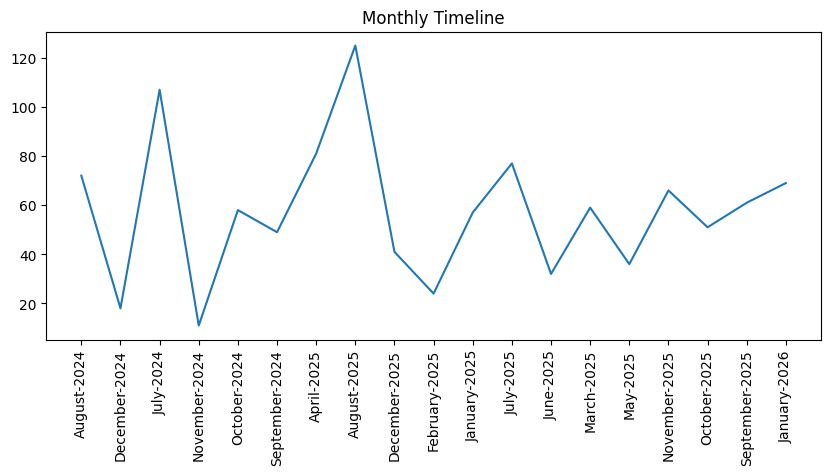

In [18]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month_name()
timeline = df.groupby(['year','month']).count()['message'].reset_index()
time = []
for i in range(timeline.shape[0]):
    time.append(timeline['month'][i] + "-" + str(timeline['year'][i]))
timeline['time'] = time
plt.figure(figsize=(10,4))
plt.plot(timeline['time'], timeline['message'])
plt.xticks(rotation=90)
plt.title("Monthly Timeline")
plt.show()


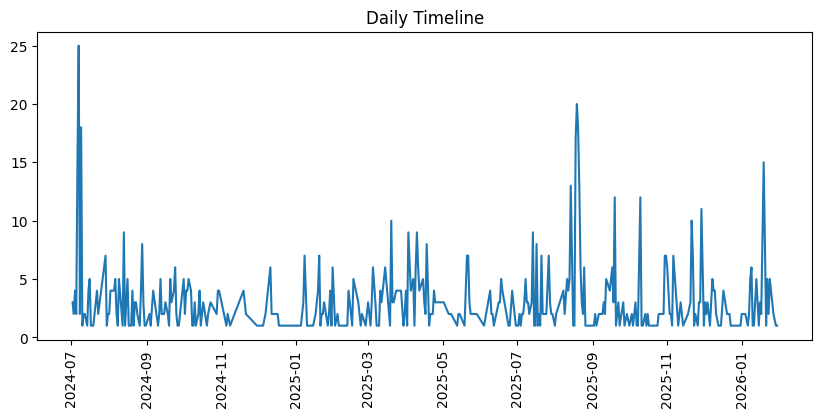

In [19]:
df['only_date'] = df['date'].dt.date
daily = df.groupby('only_date').count()['message'].reset_index()
plt.figure(figsize=(10,4))
plt.plot(daily['only_date'], daily['message'])
plt.xticks(rotation=90)
plt.title("Daily Timeline")
plt.show()

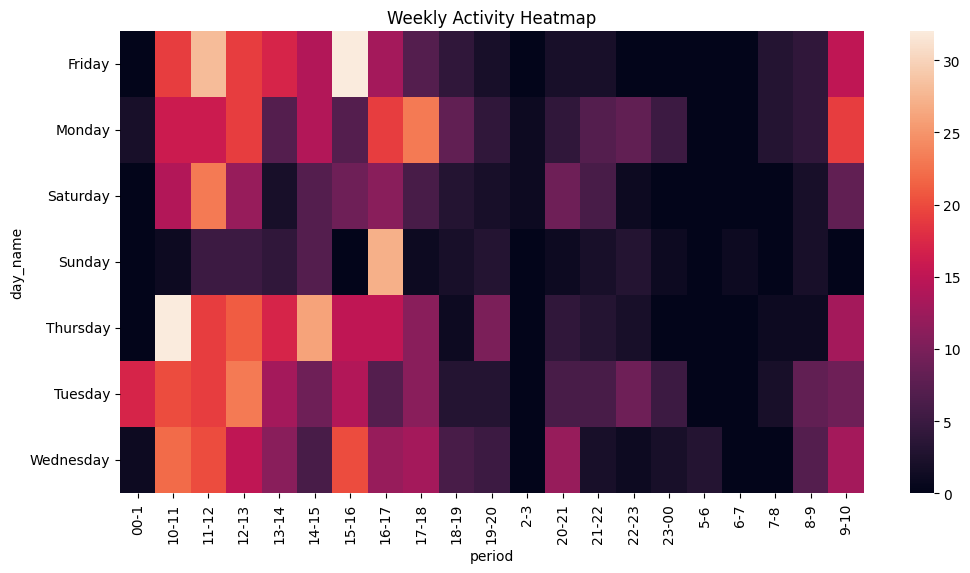

In [21]:
df['day_name'] = df['date'].dt.day_name()
df['hour'] = df['date'].dt.hour
period = []
for h in df['hour']:
    if h == 23:
        period.append("23-00")
    elif h == 0:
        period.append("00-1")
    else:
        period.append(f"{h}-{h+1}")
df['period'] = period
heatmap = df.pivot_table(
index='day_name',
    columns='period',
    values='message',
    aggfunc='count'
).fillna(0)
plt.figure(figsize=(12,6))
sns.heatmap(heatmap)
plt.title("Weekly Activity Heatmap")
plt.show()

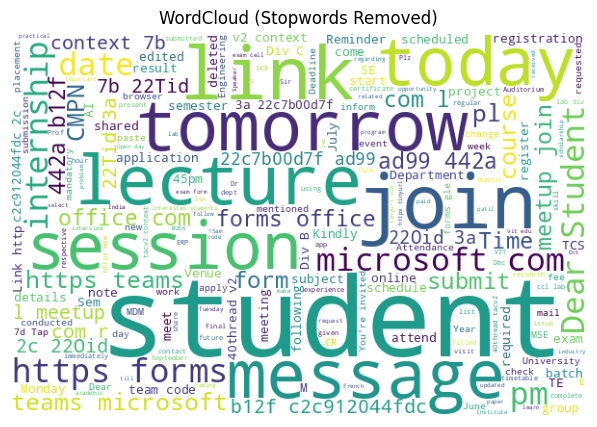

In [22]:
wc = WordCloud(
    width=600,
    height=400,
    background_color='white',
stopwords=ENGLISH_STOP_WORDS
)
wc_img = wc.generate(df['message'].str.cat(sep=" "))
plt.figure(figsize=(8,5))
plt.imshow(wc_img)
plt.axis("off")
plt.title("WordCloud (Stopwords Removed)")
plt.show()

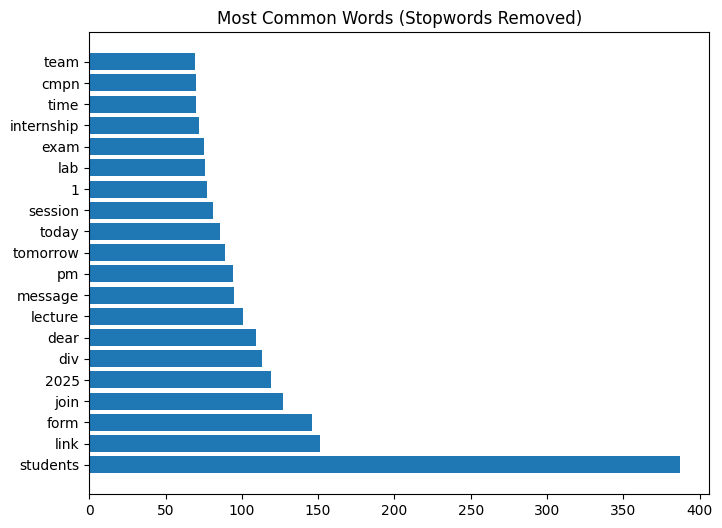

In [23]:
all_words = []
for msg in df['message']:
      for w in msg.lower().split():
            w = re.sub(r'[^\w\s]', '', w)
            if w not in ENGLISH_STOP_WORDS and w.strip() != '':
                  all_words.append(w)
common_df = pd.DataFrame(Counter(all_words).most_common(20))
plt.figure(figsize=(8,6))
plt.barh(common_df[0], common_df[1])
plt.title("Most Common Words (Stopwords Removed)")
plt.show()


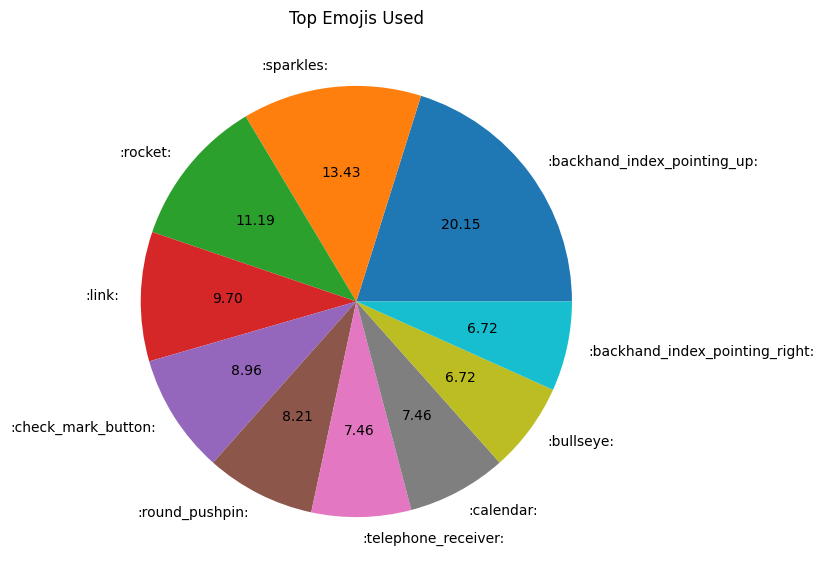

In [25]:
from collections import Counter
emojis = []
for msg in df['message']:
      emojis.extend([c for c in msg if c in emoji.EMOJI_DATA])
emoji_df = pd.DataFrame(Counter(emojis).most_common(10))
emoji_df['label'] = emoji_df[0].apply(lambda x: emoji.EMOJI_DATA[x]['en'])
plt.figure(figsize=(7,7))
plt.pie(emoji_df[1], labels=emoji_df['label'], autopct="%0.2f")
plt.title("Top Emojis Used")
plt.show()


In [26]:
df_ml = df[['message','user']]
user_counts = df_ml['user'].value_counts()
valid_users = user_counts[user_counts >= 2].index
df_ml = df_ml[df_ml['user'].isin(valid_users)]
X = df_ml['message']
y = df_ml['user']
print("Messages for ML:", X.shape[0])
print("Users for ML:", y.nunique())

Messages for ML: 1072
Users for ML: 33


In [27]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42, stratify=y
)
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [28]:
y_pred = model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.3674418604651163

Classification Report:

                 precision    recall  f1-score   support

+91 72081 55789       0.00      0.00      0.00         1
+91 77095 14267       0.00      0.00      0.00         1
+91 80826 01058       0.00      0.00      0.00         4
+91 87791 87006       0.00      0.00      0.00         4
+91 89033 86784       0.00      0.00      0.00         1
+91 89832 36225       0.00      0.00      0.00         4
+91 90047 19660       0.42      0.74      0.53        27
+91 90296 30727       0.00      0.00      0.00         9
+91 93232 32781       0.67      0.22      0.33         9
+91 93240 01786       0.00      0.00      0.00         1
+91 95527 11772       0.00      0.00      0.00        10
+91 97645 46384       0.00      0.00      0.00         1
+91 97733 21569       0.00      0.00      0.00         2
+91 98192 83485       0.00      0.00      0.00         3
+91 98201 25351       0.00      0.00      0.00         1
+91 98202 32628       1.00      0

In [29]:
sample = ["Is college open today?"]
sample_vec = vectorizer.transform(sample)
print("Predicted User:", model.predict(sample_vec)[0])

Predicted User: +91 98203 80142
